<a href="https://colab.research.google.com/github/rsadaphule/jhu-aaml/blob/main/JHU_AAML_Module_6_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive; drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
PATH_DATA = '/content/drive/My Drive/JHU/AAML/Assignments/data/surnames/'

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 72
import numpy as np

import torch
import torch.nn as nn

print(f'PyTorch version= {torch.__version__}')
print(f'CUDA available= {torch.cuda.is_available()}')

# Set the GPU to device 0
Gpu = torch.device('cuda:0')

PyTorch version= 2.0.1+cu118
CUDA available= True


In [7]:
if torch.cuda.is_available():
    # CUDA Installation
    print('CUDA Version')
    !nvcc --version
    print()

    # CUDNN Installation
    print(f'CUDNN Version: {torch.backends.cudnn.version()}')
    print(f'Number of CUDA Devices: {torch.cuda.device_count()}')
    print(f'Active CUDA Device: {torch.cuda.current_device()}')
    print(f'Available devices: {torch.cuda.device_count()}, Name: {torch.cuda.get_device_name(0)}')
    print(f'Current CUDA device: {torch.cuda.current_device()}')

CUDA Version
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0

CUDNN Version: 8700
Number of CUDA Devices: 1
Active CUDA Device: 0
Available devices: 1, Name: NVIDIA A100-SXM4-40GB
Current CUDA device: 0


In [8]:
#PATH_DATA = '../../../EP_datasets/surnames/'

# Size of the longest surname, T period
SEQ_SIZE = 20

LANGS = ('English', 'Arabic', 'Chinese', 'Czech', 'Dutch', 'French', 'German', 'Greek', 'Irish', 'Italian',
         'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese')

# Test
#LANGS = ('English', 'Arabic', 'German', 'French', 'Scottish')
#LANGS = ('English', 'Arabic', 'German')
#LANGS = ('English', 'Arabic')

LANGS_CAT = dict(zip(LANGS, range(len(LANGS))))

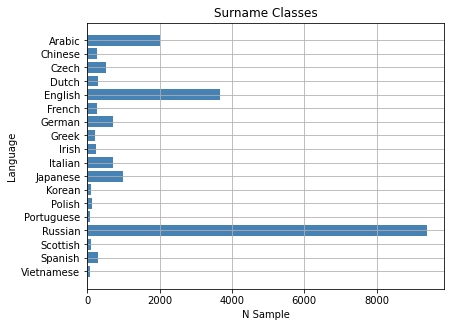

In [9]:
from os import listdir, path

langs, langs_n = [], []
for fn in sorted([_ for _ in listdir(PATH_DATA) if _.endswith('.txt')]):
    langs +=  [path.splitext(path.basename(fn))[0]]

    with open(path.join(PATH_DATA, fn), 'r', encoding="utf8") as fin:
        langs_n += [len(fin.read().splitlines())]

# plot
plt.barh(langs[::-1], langs_n[::-1], color='steelblue')
plt.xlabel('N Sample'); plt.ylabel('Language'); plt.title('Surname Classes')
plt.grid(True)
plt.show()

In [10]:
from os import listdir, path

# Letter index 0 is the padding value, i.e. padding to fill up the vector to SEQ_SIZE, necessary for batched
# Note that eventually we will use torch Tensor to represent these fixed length sequences
LetterVocabulary, LetterVocabularyIndex, Index2Voc, Sequences = {' ':0}, 1, {0:' '}, {}
for fn in sorted([_ for _ in listdir(PATH_DATA) if _.endswith('.txt')]):
    lang, seqs = path.splitext(path.basename(fn))[0], []

    if lang not in LANGS:  # test case
        continue

    with open(path.join(PATH_DATA, fn), 'r', encoding="utf8") as fin:
        for row in fin.read().splitlines():
            seq = np.zeros(SEQ_SIZE, dtype=np.int32)
            for i_, letter in enumerate(row.lower()):  # Convert the surname to lower case
#            for i_, letter in enumerate(row):
                if i_ < SEQ_SIZE:
                    if letter not in LetterVocabulary:
                        LetterVocabulary[letter] = LetterVocabularyIndex
                        Index2Voc[LetterVocabularyIndex] = letter
                        LetterVocabularyIndex += 1
                    seq[i_] = LetterVocabulary[letter]
            seqs += [seq]
    Sequences[lang] = seqs

# Sanity check
def print_names(_lang, _k):
    print(''.join([Index2Voc[c] for c in Sequences[_lang][_k]]), Sequences[_lang][_k]) if _lang in LANGS else None

# Some examples
print_names('English', 35)
print_names('Vietnamese', 3)
print_names('Irish', 3)
print_names('Arabic', 1923)
print_names('Czech', 160)
print_names('Chinese', 233)
print_names('German', 1)
print_names('Korean', 69)
print_names('Portuguese', 4)
print_names('Russian', 1678)

ainley               [ 8 14  7 16 11  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
pham                 [25  2  8 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
aodha                [ 8  3 10  2  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
maalouf              [15  8  8 16  3  4 17  0  0  0  0  0  0  0  0  0  0  0  0  0]
jarzembowski         [21  8  5 13 11 15 18  3 20  9  1 14  0  0  0  0  0  0  0  0]
lu:                  [16  4 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
abel                 [ 8 18 11 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
si                   [ 9 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
araújo               [ 8  5  8 39 21  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
bekovich-cherkassky  [18 11  1  3 28 14 22  2 24 22  2 11  5  1  8  9  9  1  6  0]


In [11]:
# Sanity
N = sum([len(Sequences[_]) for _ in Sequences])

T = Sequences['English'][0].shape[0]

C = len(np.unique(Sequences.keys())[0])

print(N, T, C)

20074 20 18


In [12]:
import itertools

# Pool all sequences and all languages
Seqs = [Sequences[LANGS[_]] for _ in range(C)]
Seqs = list(itertools.chain(*Seqs))

# Number of features is the number of unique characters
M = np.max(Seqs)  # Max sequence length
print(f'M= {M}')

M= 57


In [13]:
# Apriori class balance, i.e. inverse probability of the class
nk = np.array([len(Sequences[LANGS[_]]) for _ in range(C)], dtype=np.float32)
nk = (N/nk)
nk = nk/nk.sum()

# Class weights, inverse apriori probability
WEIGHTS = torch.tensor(nk, dtype=torch.float32)

print(WEIGHTS)

tensor([0.0032, 0.0059, 0.0439, 0.0227, 0.0396, 0.0425, 0.0163, 0.0580, 0.0507,
        0.0166, 0.0119, 0.1252, 0.0847, 0.1591, 0.0013, 0.1177, 0.0395, 0.1613])


In [14]:
# Ground truth
y = [[_]*len(Sequences[LANGS[_]]) for _ in range(C)]
y = np.array(list(itertools.chain(*y)))

In [15]:
# One-hot encode every position of the sequence
X = np.empty((N,M))
n = 0
for lang in Sequences.keys():
    for seq in Sequences[lang]:
        sxx = np.zeros((M,), dtype=np.float32)
        for i_ in range(SEQ_SIZE):  # for the duration of the signal
            if seq[i_] > 0:
                sxx[seq[i_]-1] = 1
        X[n] = sxx
        n += 1

In [16]:
%%time

# Borrowed from previous lectures
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

def kfold_eval_docs(_clf, _X, _y):
    # Need indexable data structure
    acc = []
    kf = StratifiedKFold(n_splits=10, shuffle=False, random_state=None)
    for train_index, test_index in kf.split(_X, _y):
        _clf.fit(_X[train_index], _y[train_index])
        y_pred = _clf.predict(_X[test_index])
        acc += [accuracy_score(_y[test_index], y_pred)]
    return np.array(acc)

nb = GaussianNB()
acc = kfold_eval_docs(nb, X, y)
print(f'Naive Bayes CV accuracy= {np.mean(acc):.3f} {chr(177)}{np.std(acc):.3f}')

rf = RandomForestClassifier(n_jobs=4, n_estimators=300, max_depth=10, random_state=None, class_weight='balanced')
acc = kfold_eval_docs(rf, X, y)
print(f'Random Forest CV accuracy= {np.mean(acc):.3f} {chr(177)}{np.std(acc):.3f}')

svm = SVC(kernel='rbf', gamma='scale', class_weight='balanced')
acc = kfold_eval_docs(svm, StandardScaler().fit_transform(X), y)
print(f'Support Vector Machine CV accuracy= {np.mean(acc):.3f} {chr(177)}{np.std(acc):.3f}')

Naive Bayes CV accuracy= 0.060 ±0.036
Random Forest CV accuracy= 0.463 ±0.038
Support Vector Machine CV accuracy= 0.418 ±0.040
CPU times: user 8min 22s, sys: 11.4 s, total: 8min 34s
Wall time: 8min 14s


#RNN Cassifier

In [17]:
# One-hot encode every position of the sequence
# List of sequence, language tuples for easy shuffling
def get_Xy():
    Xy = []
    for lang in Sequences.keys():
        for seq in Sequences[lang]:
            T = SEQ_SIZE  # necessary for batched
            sxx = np.zeros((T, M))
            for i in range(T):  # for the duration of the signal
                if seq[i] > 0:
                    sxx[i, seq[i]-1] = 1
            Xy += [(torch.tensor(sxx, dtype=torch.float32),
                    torch.tensor([LANGS_CAT[lang]], dtype=torch.int64))]
    return Xy

# Helper functions
def get_X(_Xy):
    return [_[0] for _ in _Xy]

def get_y(_Xy):
    return [int(_[1].data[0]) for _ in _Xy]

# Sanity
Xy = get_Xy()
print(len(Xy))

# printing the confusion matrix below
def get_cm(_y, _p):
    from sklearn.metrics import confusion_matrix
    import pandas as pd

    cm = confusion_matrix(_y, _p, labels=list(range(len(LANGS))))
    display(pd.DataFrame(cm, index=[_[:5] for _ in LANGS], columns=[_[:5] for _ in LANGS]))

20074


In [18]:
class My_RNN(nn.Module):

    def __init__(self, n_hidden, n_hid_layers=1, epochs=10, eta=0.0005, batch_size=100, weight=None, info=True):
        """ A PyTorch neural network model based on RNN cell, batched """
        super(My_RNN, self).__init__()

        self.n_hidden= n_hidden  # hidden layer size
        self.n_hid_layers= n_hid_layers  # number of hidden layers
        self.epochs= epochs  # number of learning iterations
        self.eta= eta  # learning rate
        self.B= batch_size  # size of training batch - 1 would not work
        self.info= info  # debug info

        self.rnn, self.outlayer = None, None

        self.softmax = nn.LogSoftmax(dim=1)
        # loss function, since the last layer is nn.LogSoftmax
        self.criterion = nn.NLLLoss(weight=weight)

    def forward(self, _X, _h0):
        output, hn = self.rnn(_X, _h0)
        output = self.outlayer(output[:, -1, :])  # output is batched
        output = self.softmax(output)
        return output, hn

    def init_cell(self, _M):  # Create variations of our RNN by overriding init_cell
        dropout = 0.2 if self.n_hid_layers > 1 else 0
        return nn.RNN(_M, self.n_hidden, self.n_hid_layers,
                      nonlinearity='relu',
                      bias=False, batch_first=True, dropout=dropout)

    def init_hidden(self, _B):  # batch_first = True
        return torch.zeros(self.n_hid_layers, _B, self.n_hidden).to(Gpu)  # Extra dimension - batch

    def fit(self, _Xy):
        from random import shuffle
        import sys
        import torch.optim as optim

        M= _Xy[0][0].shape[1]  # number of features, based on batch input
        C= np.unique([int(_[1].data[0]) for _ in _Xy]).shape[0]  # number of class labels

        self.rnn = self.init_cell(M).to(Gpu)
        self.outlayer = nn.Linear(self.n_hidden, C).to(Gpu)

        self.optimizer = optim.Adam(self.parameters(), lr=self.eta)

        for e in range(self.epochs):
            # Shuffle the input to randomly interleave classes, note that they are tuples, i.e. (x, y)
            shuffle(_Xy)

            N = len(_Xy)
            L, totloss = 0, 0

            while L < N-self.B:
                sxx = torch.stack([_[0] for _ in _Xy[L:L+self.B]]).to(Gpu)
                y = torch.tensor([_[1] for _ in _Xy[L:L+self.B]], dtype=torch.int64).to(Gpu)
                output, loss = self.train_signal(sxx, y, self.B)

                totloss += loss
                L += self.B

                if self.info:
                    sys.stderr.write(f"\r{e+1:03d}/{self.epochs:4d} | Loss: {loss:6.2f} | "
                                     f"Avg loss: {totloss/(e+1):6.2f} | {y.data.tolist()[0]}")
                    sys.stderr.flush()

    def train_signal(self, _sxx, _y, _B):
        h0 = self.init_hidden(_B)
        self.optimizer.zero_grad()

        output, hn = self.forward(_sxx, h0)

        loss = self.criterion(output, _y)
        loss.backward()
        self.optimizer.step()
        return output, loss.item()

    def predict(self, _sxx):  # Tensor dimensions: B x T x M
        _sxx = torch.stack(_sxx)
        with torch.no_grad():
            h0 = self.init_hidden(_sxx.shape[0])  # reset the hidden layer
            output, hn = self.forward(_sxx.to(Gpu), h0)

        p_values, indices = output.max(dim=1)
        return indices.to('cpu')


# Info about the RNN
print(My_RNN(10, n_hid_layers=1, eta=0.001))

My_RNN(
  (softmax): LogSoftmax(dim=1)
  (criterion): NLLLoss()
)


In [19]:
%%time

Xy = get_Xy()

Acc = []
for _ in range(1):  # Statistical variation

    rnn = My_RNN(128, n_hid_layers=2, epochs=1000, eta=0.005, batch_size=2000, weight=WEIGHTS, info=True).to(Gpu)
    rnn.fit(Xy)

    y_pred = rnn.predict(get_X(Xy))
    Acc += [np.sum(np.array(y_pred) == np.array(get_y(Xy)))/len(y_pred)]

print(f'RNN reclassification Acc= {np.mean(Acc):.2f} {chr(177)}{np.std(Acc):.3f}')

1000/1000 | Loss:   0.43 | Avg loss:   0.00 | 2

RNN reclassification Acc= 0.76 ±0.000
CPU times: user 6min 54s, sys: 4.16 s, total: 6min 58s
Wall time: 2min 40s


In [20]:
get_cm(get_y(Xy), y_pred)

,Engli,Arabi,Chine,Czech,Dutch,Frenc,Germa,Greek,Irish,Itali,Japan,Korea,Polis,Portu,Russi,Scott,Spani,Vietn
Engli,1736,17,57,161,285,304,450,13,184,35,10,12,12,18,64,240,67,3
Arabi,0,1939,0,1,0,11,0,17,13,0,15,1,0,0,0,3,0,0
Chine,2,0,238,0,0,4,1,0,0,0,0,16,0,0,0,0,0,7
Czech,17,0,1,424,5,3,35,0,0,2,9,0,11,0,7,4,1,0
Dutch,3,0,2,1,275,6,5,0,0,0,0,0,0,0,0,1,3,1
Frenc,8,1,3,0,0,247,2,0,5,0,0,0,2,0,0,3,6,0
Germa,27,1,2,14,40,19,603,0,3,0,0,2,3,0,1,2,6,1
Greek,1,0,0,0,0,2,0,195,0,3,0,0,0,0,0,0,2,0
Irish,7,0,0,0,0,3,0,0,215,0,0,0,0,0,0,7,0,0
Itali,3,2,1,2,0,7,0,4,1,630,7,0,2,10,4,0,36,0


In [21]:
%%time

Xy = get_Xy()

cm_y, cm_p = [], []

Acc = []
kf = StratifiedKFold(n_splits=10)
for tr_ix, ts_ix in kf.split(np.arange(len(Xy)), get_y(Xy)):
    rnn = My_RNN(128, n_hid_layers=2, epochs=1000, eta=0.005, batch_size=2000, weight=WEIGHTS, info=True).to(Gpu)

    X_tr = [Xy[_] for _ in tr_ix]  # predict uses X and y as a tuple
    X_ts = get_X([Xy[_] for _ in ts_ix])
    y_ts = get_y([Xy[_] for _ in ts_ix])

    rnn.fit(X_tr)
    y_pred = rnn.predict(X_ts)

    Acc += [np.sum(np.array(y_pred) == np.array(y_ts))/len(y_pred)]

    cm_y += y_ts
    cm_p += y_pred.tolist()

print(f'RNN 10-fold CV Acc= {np.mean(Acc):.2f} {chr(177)}{np.std(Acc):.3f}')

1000/1000 | Loss:   0.40 | Avg loss:   0.00 | 14

RNN 10-fold CV Acc= 0.59 ±0.039
CPU times: user 1h 1min 1s, sys: 25 s, total: 1h 1min 26s
Wall time: 21min 51s


# LSTM classifier

In [22]:
class My_LSTM(My_RNN):

    def __init__(self, n_hidden, n_hid_layers=1, epochs=10, eta=0.0005, batch_size=100, weight=None, info=True):
        """ A PyTorch neural network model based on LSTM RNN cell, batched """
        super(My_LSTM, self).__init__(n_hidden, n_hid_layers=n_hid_layers,
                                      epochs=epochs, eta=eta, batch_size=batch_size, weight=weight, info=info)

    def init_hidden(self, _B):  # batch_first = True
        return (torch.zeros(self.n_hid_layers, _B, self.n_hidden).to(Gpu),
                torch.zeros(self.n_hid_layers, _B, self.n_hidden).to(Gpu))

    def init_cell(self, _M):  # override
        dropout = 0.2 if self.n_hid_layers > 1 else 0
        return nn.LSTM(_M, self.n_hidden, self.n_hid_layers,
                       #nonlinearity='relu',
                       bias=False, batch_first=True, dropout=dropout)

# Info about the RNN
print(My_LSTM(10, n_hid_layers=1, eta=0.001))

My_LSTM(
  (softmax): LogSoftmax(dim=1)
  (criterion): NLLLoss()
)


In [23]:
%%time

Xy = get_Xy()

Acc = []
for _ in range(1):  # Statistical variation

    rnn = My_LSTM(128, n_hid_layers=1, epochs=1000, eta=0.005, batch_size=2000, weight=WEIGHTS, info=True).to(Gpu)
    rnn.fit(Xy)

    y_pred = rnn.predict(get_X(Xy))
    Acc += [np.sum(np.array(y_pred) == np.array(get_y(Xy)))/len(y_pred)]

print(f'RNN reclassification Acc= {np.mean(Acc):.2f} {chr(177)}{np.std(Acc):.3f}')

1000/1000 | Loss:   0.11 | Avg loss:   0.00 | 9

RNN reclassification Acc= 0.95 ±0.000
CPU times: user 7min 17s, sys: 2.94 s, total: 7min 20s
Wall time: 2min 39s


In [24]:
get_cm(get_y(Xy), y_pred)

,Engli,Arabi,Chine,Czech,Dutch,Frenc,Germa,Greek,Irish,Itali,Japan,Korea,Polis,Portu,Russi,Scott,Spani,Vietn
Engli,3281,5,12,9,11,51,39,1,64,7,5,8,4,13,27,119,8,4
Arabi,0,2000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Chine,0,0,240,0,1,0,0,0,0,0,0,18,0,0,0,1,0,8
Czech,0,0,0,505,2,1,3,0,0,0,0,0,5,0,0,3,0,0
Dutch,0,0,1,0,290,3,1,0,1,0,0,0,1,0,0,0,0,0
Frenc,0,0,1,0,1,265,0,0,3,0,0,0,5,0,0,1,1,0
Germa,0,1,1,9,23,13,664,0,4,0,0,2,4,0,0,1,1,1
Greek,0,0,0,0,0,0,0,203,0,0,0,0,0,0,0,0,0,0
Irish,0,0,0,0,0,0,0,0,226,0,0,0,0,0,0,6,0,0
Itali,0,0,1,0,2,1,0,0,0,673,0,0,2,9,0,0,21,0


In [25]:
'''
This code takes forever . Hence commneted out
%%time

Xy = get_Xy()

cm_y, cm_p = [], []

Acc = []
kf = StratifiedKFold(n_splits=10)
for tr_ix, ts_ix in kf.split(np.arange(len(Xy)), get_y(Xy)):
    rnn = My_LSTM(128, n_hid_layers=1, epochs=1000, eta=0.005, batch_size=2000, weight=WEIGHTS, info=True).to(Gpu)

    X_tr = [Xy[_] for _ in tr_ix]  # predict uses X and y as a tuple
    X_ts = get_X([Xy[_] for _ in ts_ix])
    y_ts = get_y([Xy[_] for _ in ts_ix])

    rnn.fit(X_tr)
    y_pred = rnn.predict(X_ts)

    Acc += [np.sum(np.array(y_pred) == np.array(y_ts))/len(y_pred)]

    cm_y += y_ts
    cm_p += y_pred.tolist()

print(f'RNN 10-fold CV Acc= {np.mean(Acc):.2f} {chr(177)}{np.std(Acc):.3f}')
...
'''

" \nThis code takes forever . Hence commneted out\n%%time\n\nXy = get_Xy()\n\ncm_y, cm_p = [], []\n\nAcc = []\nkf = StratifiedKFold(n_splits=10)\nfor tr_ix, ts_ix in kf.split(np.arange(len(Xy)), get_y(Xy)):\n    rnn = My_LSTM(128, n_hid_layers=1, epochs=1000, eta=0.005, batch_size=2000, weight=WEIGHTS, info=True).to(Gpu)\n\n    X_tr = [Xy[_] for _ in tr_ix]  # predict uses X and y as a tuple\n    X_ts = get_X([Xy[_] for _ in ts_ix])\n    y_ts = get_y([Xy[_] for _ in ts_ix])\n\n    rnn.fit(X_tr)\n    y_pred = rnn.predict(X_ts)\n\n    Acc += [np.sum(np.array(y_pred) == np.array(y_ts))/len(y_pred)]\n\n    cm_y += y_ts\n    cm_p += y_pred.tolist()\n\nprint(f'RNN 10-fold CV Acc= {np.mean(Acc):.2f} {chr(177)}{np.std(Acc):.3f}')\n...\n"

In [26]:
# get_cm(cm_y, cm_p)

[20 pts]
1. List three popular RNN types, then briefly compare and contrast their features and
applications.

Ans -
Here are three popular types of recurrent neural networks (RNNs) and a brief comparison of their features and applications:

* LSTM (Long Short-Term Memory) - Designed to address the vanishing gradient problem in basic RNNs. Includes a memory cell and gates to better preserve long-term dependencies. Often used for speech recognition, language translation, and time series forecasting.
* GRU (Gated Recurrent Unit) - Simpler variation of the LSTM that combines the forget and input gates into a single "update gate." Performs similarly to LSTMs on many tasks while being more computationally efficient. Used for speech, text, and time series data.
* Bidirectional RNN - Processes sequence data in both directions with forward and backward hidden layers. Provides additional context for each point in the input sequence. Useful for tasks like speech recognition where future context is informative.



Here is a more  comparison of the three RNN types:

* LSTM:
It has a memory cell that can maintain information over long sequences. This helps preserve long-term dependencies that vanish in basic RNNs. It uses input, output, and forget gates to control information flow into and out of the memory cell. It allows selective memorization and forgetting. More complex structure leads to higher parameter count but better performance on tasks with long-term dependencies.

* GRU:
It lacks an explicit memory cell. Instead exposes the full hidden state each timestep. It combines the input and forget gates into a single "update gate." This reduces parameters compared to LSTM. It performs similarly to LSTMs on many tasks but with greater computational efficiency. They are overall simpler gated architecture compared to LSTM.

* Bidirectional RNN:
It processes sequence data in both directions with forward and backward passes.
Forward and backward hidden states are concatenated, giving each timestep full past and future context. It is useful when future context is informative about the current timestep. It adds broader context compared to unidirectional RNNs.
Bidirectional structure can be applied to various RNN architectures including LSTM and GRU. It has twice the number of RNN parameters since there are separate forward and backward networks.

In summary, LSTMs have the highest performance and model complexity due to their memory cells and gating units. GRUs are simpler and more efficient but may not learn very complex temporal patterns. Bidirectional RNNs add broader context compared to unidirectional, at the cost of more parameters.


2. [20 pts]
Explain why the LSTM RNN performed superbly compared to the other classifiers in the module including the regular classifiers.

Ans -
Memory Cells: LSTM units have a unique design that includes memory cells, gates (input, forget, and output gates), and a hidden state. This design allows LSTMs to store and recall information over long sequences, making them particularly effective for tasks that involve sequential data, like surnames in different languages.

Handling Long-Term Dependencies: One of the main challenges with basic RNNs is the vanishing gradient problem, which makes it difficult for the RNN to learn and remember information from earlier time steps in long sequences. LSTMs are specifically designed to address this issue, allowing them to capture long-term dependencies in the data.

Gating Mechanisms: The gates in the LSTM units decide what information to store, discard, or output at each time step. This selective ability helps LSTMs manage and prioritize the information flow, making them more effective in understanding the structure and patterns in sequential data.

Regularization: The dropout mechanism, which can be applied between LSTM layers, helps prevent overfitting, especially when dealing with a large number of parameters.

Batch Training: The code uses batch training, which can help in stabilizing the learning process and speeding up convergence. LSTMs can benefit from this, especially when trained on large datasets.

Class Imbalance Handling: The code uses class weights (WEIGHTS) to handle class imbalance. This ensures that minority classes are given more importance during training, which can improve the overall classification performance.

Flexibility: Neural networks, including LSTMs, have the ability to learn complex non-linear relationships. This flexibility can allow them to outperform traditional classifiers, especially when there's enough data to train on.

Optimization: The use of the Adam optimizer, which adjusts the learning rate during training, can help in faster and more stable convergence.

Data Representation: One-hot encoding of the sequences ensures that the input data is in a format that's suitable for neural network training. This representation can capture the nuances in the data better than some traditional feature extraction methods.

3. [20 pts]
Build a classifier using only two languages {English and Scottish} from the surname dataset
to distinguish between them. Report 10-fold cross validation performance.


In [27]:
def get_Xy():
    Xy = []
    for lang in LANGS:  # Only process the languages in LANGS
        for seq in Sequences[lang]:
            T = SEQ_SIZE  # necessary for batched
            sxx = np.zeros((T, M))
            for i in range(T):  # for the duration of the signal
                if seq[i] > 0:
                    sxx[i, seq[i]-1] = 1
            Xy += [(torch.tensor(sxx, dtype=torch.float32),
                    torch.tensor([LANGS_CAT[lang]], dtype=torch.int64))]
    return Xy


In [28]:
# Apriori class balance, i.e. inverse probability of the class for only English and Scottish
nk = np.array([len(Sequences['English']), len(Sequences['Scottish'])], dtype=np.float32)
N = sum(nk)
nk = (N/nk)
nk = nk/nk.sum()

# Class weights, inverse apriori probability for only English and Scottish
WEIGHTS = torch.tensor(nk, dtype=torch.float32)


In [29]:
from sklearn.model_selection import StratifiedKFold

import os

# Only consider English and Scottish surnames
LANGS = ('English', 'Scottish')
LANGS_CAT = dict(zip(LANGS, range(len(LANGS))))


def load_surnames_from_file(filepath):
    with open(filepath, 'r', encoding="utf8") as f:
        return f.read().splitlines()

# Assuming the dataset is in a folder named 'surnames'
english_surnames = load_surnames_from_file(PATH_DATA + 'English.txt')
scottish_surnames = load_surnames_from_file(PATH_DATA  + 'Scottish.txt')

# Label the data: 0 for English, 1 for Scottish
data = [(name, 0) for name in english_surnames] + [(name, 1) for name in scottish_surnames]


#Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

names, labels = zip(*data)
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1,3))
X = vectorizer.fit_transform(names)
y = labels


#training
Xy = get_Xy()

cm_y, cm_p = [], []
Acc = []

kf = StratifiedKFold(n_splits=10)
for tr_ix, ts_ix in kf.split(np.arange(len(Xy)), get_y(Xy)):
    rnn = My_LSTM(128, n_hid_layers=1, epochs=1000, eta=0.005, batch_size=2000, weight=WEIGHTS, info=True).to(Gpu)

    X_tr = [Xy[_] for _ in tr_ix]  # predict uses X and y as a tuple
    X_ts = get_X([Xy[_] for _ in ts_ix])
    y_ts = get_y([Xy[_] for _ in ts_ix])

    rnn.fit(X_tr)
    y_pred = rnn.predict(X_ts)

    Acc += [np.sum(np.array(y_pred) == np.array(y_ts))/len(y_pred)]
    cm_y += y_ts
    cm_p += y_pred.tolist()

print(f'LSTM 10-fold CV Acc= {np.mean(Acc):.2f} ± {np.std(Acc):.3f}')


1000/1000 | Loss:   0.06 | Avg loss:   0.00 | 0

LSTM 10-fold CV Acc= 0.63 ± 0.245


4. [40 pts]
Determine an optimum sequence length (i.e., surname length), by finding a sweet spot
between the run-time (due to the sequence length) and the classification performance.

In [31]:
# Preprocess data
def get_Xy():
    Xy = []
    for lang in LANGS:
        for seq in Sequences[lang]:
            T = SEQ_SIZE
            sxx = np.zeros((T, M))
            for i in range(T):
                if seq[i] > 0:
                    sxx[i, seq[i]-1] = 1
            Xy.append((torch.tensor(sxx, dtype=torch.float32),
                       torch.tensor([LANGS_CAT[lang]], dtype=torch.int64)))
    return Xy


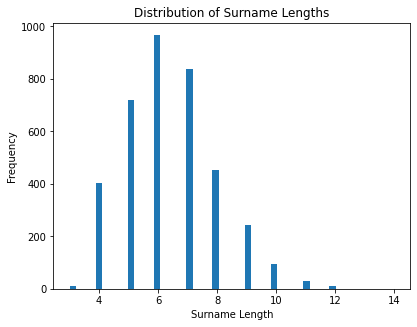

[5, 5, 6, 4, 4, 7, 8, 6, 6, 7, 5, 5, 4, 5, 7, 6, 6, 8, 8, 5, 7, 6, 7, 4, 6, 5, 5, 5, 6, 4, 5, 6, 5, 5, 6, 6, 9, 4, 5, 9, 6, 6, 5, 4, 7, 5, 6, 10, 6, 6, 5, 5, 9, 8, 6, 6, 8, 8, 8, 9, 9, 9, 6, 5, 3, 5, 7, 5, 5, 6, 7, 7, 7, 9, 8, 5, 7, 9, 7, 7, 7, 6, 7, 6, 5, 7, 6, 5, 5, 6, 7, 5, 5, 5, 7, 8, 4, 5, 4, 4, 4, 6, 8, 9, 8, 6, 7, 5, 5, 5, 5, 8, 6, 6, 7, 5, 5, 6, 6, 5, 7, 8, 9, 6, 4, 6, 6, 6, 5, 8, 6, 7, 9, 6, 6, 6, 6, 10, 7, 6, 7, 9, 8, 5, 8, 7, 4, 5, 7, 6, 6, 6, 7, 7, 8, 5, 5, 4, 5, 5, 8, 7, 5, 6, 5, 8, 10, 8, 5, 6, 8, 6, 5, 9, 8, 8, 7, 7, 8, 6, 6, 6, 6, 5, 6, 5, 4, 4, 4, 4, 6, 5, 7, 6, 6, 7, 5, 5, 4, 5, 6, 4, 10, 6, 5, 5, 5, 7, 4, 4, 10, 7, 7, 8, 5, 6, 9, 6, 7, 6, 6, 7, 6, 7, 5, 4, 7, 6, 6, 5, 8, 6, 4, 7, 9, 4, 7, 5, 4, 6, 5, 6, 7, 6, 4, 5, 7, 4, 4, 7, 6, 8, 4, 7, 5, 4, 5, 4, 7, 8, 8, 7, 6, 7, 6, 7, 5, 4, 7, 5, 5, 9, 7, 6, 5, 4, 4, 7, 10, 5, 4, 6, 7, 5, 9, 8, 9, 9, 5, 5, 8, 6, 9, 5, 6, 5, 8, 6, 3, 5, 6, 6, 4, 4, 6, 4, 5, 7, 7, 7, 6, 6, 6, 5, 5, 6, 5, 6, 6, 6, 5, 4, 5, 6, 8, 7, 8, 5, 5, 11, 7,

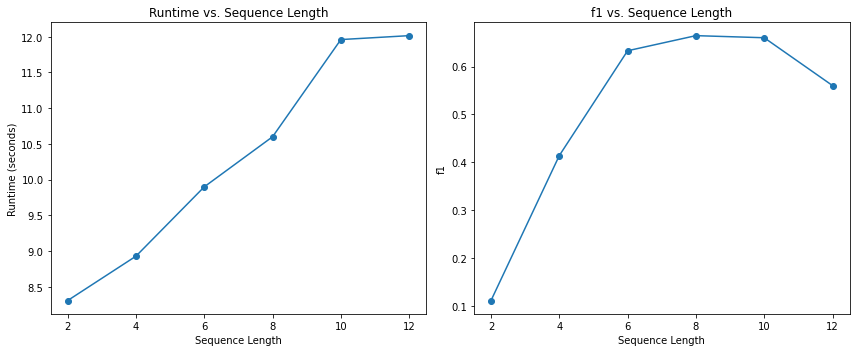

In [38]:
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

# Load surnames from file
def load_surnames_from_file(filepath):
    with open(filepath, 'r', encoding="utf8") as f:
        return f.read().splitlines()

# Only consider English and Scottish surnames
LANGS = ('English', 'Scottish')
LANGS_CAT = dict(zip(LANGS, range(len(LANGS))))

# Assuming the dataset is in a folder named 'surnames'
english_surnames = load_surnames_from_file(PATH_DATA + 'English.txt')
scottish_surnames = load_surnames_from_file(PATH_DATA  + 'Scottish.txt')


# Combine and label the data
data = [(name, 0) for name in english_surnames] + [(name, 1) for name in scottish_surnames]
names, labels = zip(*data)



# Analyze the distribution of surname lengths
surname_lengths = [len(name) for name in names]
#print(max(surname_lengths))


plt.hist(surname_lengths, bins=50)
plt.xlabel('Surname Length')
plt.ylabel('Frequency')
plt.title('Distribution of Surname Lengths')
plt.show()


#Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

names, labels = zip(*data)
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1,3))
X = vectorizer.fit_transform(names)
y = labels





# Experiment with different sequence lengths
sequence_lengths = list(range(2, max(surname_lengths), 2))
#print(surname_lengths)
performances = []
runtimes = []


for seq_len in sequence_lengths:
    SEQ_SIZE = seq_len  # Adjust the sequence size
    #print("sequence size: ")
    #print(SEQ_SIZE)
     # Data preprocessing (adjust for the new sequence length)
    Xy = get_Xy()

    # Train the LSTM model
    start_time = time.time()

    Xy = get_Xy()
    rnn = My_LSTM(128, n_hid_layers=1, epochs=1000, eta=0.005, batch_size=2000, weight=WEIGHTS, info=False).to(Gpu)
    rnn.fit(Xy)

    y_pred = rnn.predict(get_X(Xy))
    f1 = f1_score(get_y(Xy), y_pred)
    acc = np.sum(np.array(y_pred) == np.array(get_y(Xy)))/len(y_pred)

    end_time = time.time()

    # Record performance and runtime
    #performances.append(acc)
    performances.append(f1)
    runtimes.append(end_time - start_time)

# Plot runtime and performance against sequence lengths
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(sequence_lengths, runtimes, '-o')
plt.xlabel('Sequence Length')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime vs. Sequence Length')

plt.subplot(1, 2, 2)
plt.plot(sequence_lengths, performances, '-o')
plt.xlabel('Sequence Length')
plt.ylabel('f1')
plt.title('f1 vs. Sequence Length')

plt.tight_layout()
plt.show()



# Analysis
* The surnames lengths vary from 1 to 12
* The runtime of algorithm increase as sequence length increases until sequence length of 10 beyond which runtime does not change significnatlt
* The f1 score of algorith increases as sequence length increase upto a lnegth of 10 beyind which it starts dropping
* It is upto use case where we we need to decide what we want to optimize for
** If we we want to optimize for f1 score I would choose a sequence length of 10
** If we want to optimize for runtime a sequence length of 8 would be good choice as f1 score for sequence length of 8 is not too differenet from that of 10.
